# Ensemble Learning(앙상블 학습방법)

*   앙상블(ensemble): ML에서 사용되는 일련의 모델(알고리즘)들.
    *   서로 다른 모델(알고리즘) 여러 개를 학습시키는 방법.
    *   한 가지 모델을 서로 다른 훈련 셋으로 학습시키는 방법.
*   앙상블 학습방법: 앙상블을 사용한 학습방법.
    *   투표(voting) 방식: 여러 개의 모델들을 학습시킨 후, 각각의 모델들의 예측값을 투표(최빈값, 평균)로 결정하는 방식.
    *   __Bagging(Bootstrap Aggregating)__: __중복을 허용__해서 샘플링한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측(최빈값, 평균)하는 방법.
    *   Pasting: 중복을 허용하지 않고 샘플힝한 훈련 셋의 부분집합들을 알고리즘에 학습시켜서 예측하는 방법.
    *   __Boosting__: 약한 학습기(weak learner)를 순차적으로 연결해서 강한 학습기(strong learner)를 만드는 앙상블 학습방법.
        *   AdaBoost(Adpative Boosting): 과소적합됐던 훈련 샘플들의 가중치를 높여서 그 다음 학습에서 사용하는 boosting 방법.
        *   Gradient Boosting: 잔여 오차(residual errors)들을 다음 훈련에서 학습시키는 boosting 방법.
*   __Random Forest__: Bagging을 사용한 Decision Tree들의 앙상블 학습방법.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier

# Datasets 준비

2개의 특성(x1, x2)과 2개 클래스(0, 1)를 갖는 가상의 데이터셋을 만들고 사용.

In [ ]:
# X: 특성 배열, y: 타겟 배열
X, y = datasets.make_moons(n_samples=500, random_state=42, noise=0.3)

In [ ]:
X.shape

(500, 2)

In [ ]:
y.shape

(500,)

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([250, 250]))

특성 배열을 타겟에 따라서 다른 색깔로 시각화

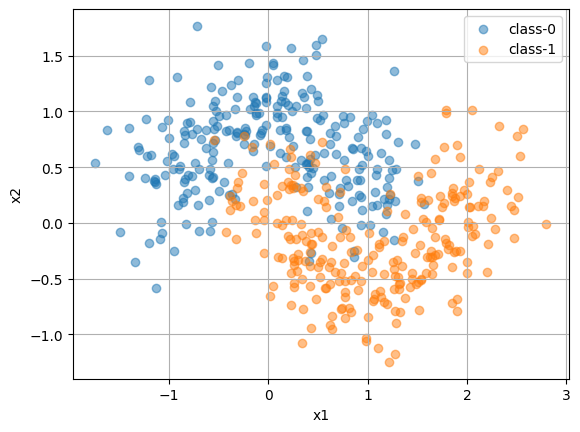

In [ ]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], label= 'class-0', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label= 'class-1', alpha=0.5)

plt.grid()
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [ ]:
# 훈련/테스트 나누기
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 머신 러닝 모델의 성능 비교

*   5개의 ML 모델 생성
    *   KNN, Decision Tree, Logistic Regression, SGD, SVM 기본 생성자
        *   SGDClassifier의 파라미터 중에서 loss='log_loss' 사용.
        *   SVC의 파라미터 중에서 probability=True 사용.
*   5개의 모델을 각각 훈련 셋으로 학습시킴
*   5개 모델의 점수(score -> 정확도)를 훈련/테스트 셋에서 계산, 출력.

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)
tree = DecisionTreeClassifier(random_state=42)
logistic = LogisticRegression(random_state=42, n_jobs=-1)
sgd = SGDClassifier(loss='log_loss', random_state=42, n_jobs=-1)
#> loss='log_loss' 설정 이유: 각 클래스가 될 확률을 계산하기 위해서
svm = SVC(probability=True, random_state=42)
#> probability=True 설정 이유: 각 클래스가 될 확률을 계산하기 위해서

In [ ]:
classifiers = [knn, tree, logistic, sgd, svm]
for clf in classifiers:
    clf.fit(X_tr, y_tr)  # 모델 훈련
    train_score = clf.score(X_tr, y_tr)
    test_score = clf.score(X_te, y_te)
    print(f'{clf.__class__.__name__}: train score={train_score}, test score={test_score}')

KNeighborsClassifier: train score=0.93, test score=0.93
DecisionTreeClassifier: train score=1.0, test score=0.84
LogisticRegression: train score=0.8475, test score=0.81
SGDClassifier: train score=0.8425, test score=0.81
SVC: train score=0.9275, test score=0.93


# Voting Ensemble

In [ ]:
vote_clf = VotingClassifier(estimators=[('knn', knn),
                                        ('tree', tree),
                                        ('logistic', logistic),
                                        ('sgd', sgd),
                                        ('svm', svm)],
                            voting='soft',
                            n_jobs=-1)
# estimators: 앙상블을 만들기 위한 예측기(ML 모델)들의 리스트.
#   ('name', estimator) 튜플들의 리스트로 전달.
# voting='hard': 기본값. 단순한 다수결. 각 모델에서 예측 확률을 계산할 필요가 없음.
# voting='soft': 각 모델의 예측값에 예측 확률을 가중치로 곱한 값을 사용해서 최종 결과를 예측.
# 일반적으로 soft voting 방식이 성능이 더 좋다고 알려져 있음.

In [ ]:
vote_clf.fit(X_tr, y_tr)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_jobs=-1)),
                             ('tree', DecisionTreeClassifier(random_state=42)),
                             ('logistic',
                              LogisticRegression(n_jobs=-1, random_state=42)),
                             ('sgd',
                              SGDClassifier(loss='log_loss', n_jobs=-1,
                                            random_state=42)),
                             ('svm', SVC(probability=True, random_state=42))],
                 n_jobs=-1, voting='soft')

In [ ]:
print('train score=', vote_clf.score(X_tr, y_tr))
print('test score=', vote_clf.score(X_te, y_te))

train score= 0.94
test score= 0.92


# Baggomg Ensemble

BaggingClasifier의 파라미터들:

*   base_estimator: 기본 추정기(예측기). 머신 러닝 모델 객체.
*   n_etimators: 추정기(예측기)의 개수. 기본값 10.
*   max_samples: 훈련 셋의 부분 집합이 가질 수 있는 최대 샘플 개수(정수) 또는 비율(0 ~ 1.0). 기본값은 1.0.
*   bootstrap: True(중복 허용 샘플링, bagging). False(중복 불허 샘플링, pasting). 기본값은 True.
*   oob_score: True(OOB 샘플로 평가 점수 계산). False(OOB 샘플로 평가 점수를 계산하지 않음). 기본값은 False.
    *   OOB(Out-Of-Bagging) 샘플: 중복 허용 샘플링을 하는 동안 한 번도 샘플링되지 못하고 남아 있는 훈련 셋의 샘플.
    *   OOB sample은 validation set 역할을 할 수 있음.


In [ ]:
bagging_clf = BaggingClassifier(estimator= DecisionTreeClassifier(random_state= 42),
                                n_estimators= 50,
                                oob_score= True,
                                n_jobs= -1,
                                random_state = 42)

In [ ]:
bagging_clf.fit(X_tr, y_tr)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=50, n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
bagging_clf.score(X_tr, y_tr)          # 훈련 셋 정확도

1.0

In [ ]:
bagging_clf.score(X_te, y_te)          # 테스트 셋 정확도

0.89

In [ ]:
bagging_clf.oob_score_              # oob: out of bagging

0.89

*   estimator = DeicisionTree() 사용
*   n_estimators = 100 설정하고 교차검증(cross_validate)
*   n_estomators = 50, max_samples = 100 설정하고 교차검증(cross_validate)

In [ ]:
bagging_clf100 = BaggingClassifier(estimator= DecisionTreeClassifier(random_state= 42),
                                n_estimators= 100,
                                n_jobs= -1,
                                random_state = 42)

In [ ]:
cv = cross_validate(estimator = bagging_clf100, X = X_tr, y= y_tr, cv = 5, n_jobs= -1, return_train_score = True)

In [ ]:
cv

{'fit_time': array([0.80652142, 0.85701084, 0.86690712, 1.00588536, 0.86310983]),
 'score_time': array([0.1040206 , 0.06857586, 0.09086967, 0.07956886, 0.07624769]),
 'test_score': array([0.875 , 0.925 , 0.9375, 0.925 , 0.875 ]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [ ]:
np.mean(cv['train_score'])

np.float64(1.0)

In [ ]:
np.mean(cv['test_score'])

np.float64(0.9075)

In [ ]:
bagging_clf50 =  BaggingClassifier(estimator= DecisionTreeClassifier(random_state= 42),
                                   n_estimators = 50,
                                   max_samples= 100,
                                   n_jobs= -1,
                                   random_state= 42)

In [ ]:
cv2 = cross_validate(estimator= bagging_clf50, X = X_tr, y = y_tr, cv = 5, n_jobs= -1, return_train_score = True)

In [ ]:
cv2

{'fit_time': array([0.56864166, 0.5847137 , 0.33108354, 0.40107751, 0.32860303]),
 'score_time': array([0.02832341, 0.06354308, 0.04104161, 0.08582187, 0.04356194]),
 'test_score': array([0.875 , 0.95  , 0.9125, 0.9   , 0.925 ]),
 'train_score': array([0.95    , 0.93125 , 0.946875, 0.940625, 0.940625])}

In [ ]:
np.mean(cv2['train_score'])

np.float64(0.9418749999999999)

In [ ]:
np.mean(cv2['test_score'])

np.float64(0.9125)

# Random Forest

bagging을 사용한 Decision Tree들의 앙상블 학습.

In [ ]:
forest_clf = RandomForestClassifier(n_estimators= 50, max_samples= 100,
                                    random_state = 42, n_jobs= -1)

Random Forest: bagging을 사용한  Decision Tree 들의 앙상블 학습.
*   DecisionTreeClassifier와 BaggingClassifier의 파라미터들을 갖음.
*   GridSearchCV 또는 RandomizedSearchCV을 사용해서 tree와 bagging의 하이퍼 파라미터들을 튜닝할 수 있음.

In [ ]:
cv = cross_validate(estimator = forest_clf, X = X_tr, y= y_tr, return_train_score = True, n_jobs= -1)

In [ ]:
cv

{'fit_time': array([0.4255507 , 0.46511269, 0.26892138, 0.23126245, 0.17828989]),
 'score_time': array([0.05741644, 0.01704788, 0.03925943, 0.056144  , 0.02808738]),
 'test_score': array([0.8875, 0.975 , 0.925 , 0.9125, 0.9375]),
 'train_score': array([0.953125, 0.946875, 0.94375 , 0.95    , 0.953125])}

In [ ]:
print('train_score: ', np.mean(cv['train_score']))
print('test_score: ', np.mean(cv['test_score']))

train_score:  0.9493750000000001
test_score:  0.9274999999999999


# Random Forest를 사용한 wine 데이터셋 분류

## 데이터 셋 준비

In [ ]:
wine_csv = 'https://bit.ly/wine_csv_data'

In [ ]:
wine = pd.read_csv(wine_csv)

In [ ]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [ ]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [ ]:
X = wine[wine.columns[:3]].values
X

array([[ 9.4 ,  1.9 ,  3.51],
       [ 9.8 ,  2.6 ,  3.2 ],
       [ 9.8 ,  2.3 ,  3.26],
       ...,
       [ 9.4 ,  1.2 ,  2.99],
       [12.8 ,  1.1 ,  3.34],
       [11.8 ,  0.8 ,  3.26]])

In [ ]:
y = wine[wine.columns[-1:]].values

In [ ]:
X_tr,  X_te, y_tr, y_te = train_test_split(X, y,
                                        test_size= 0.2,
                                        random_state = 42,
                                        stratify=y)

## 모델 훈련

In [ ]:
forest_clf = RandomForestClassifier( n_jobs= -1, random_state = 42)

In [ ]:
cv = cross_validate(estimator= forest_clf, X = X_tr, y = y_tr, n_jobs= -1, return_train_score= True)

In [ ]:
np.mean(cv['train_score'])

np.float64(0.9981720130385032)

In [ ]:
np.mean(cv['test_score'])

np.float64(0.8937817428000298)

        --> Random Forest는 과대적합이 크다.

## 하이퍼 파라미터 튜닝

In [ ]:
# estimator 생성
forest_clf = RandomForestClassifier(n_jobs= -1, random_state= 42)

In [ ]:
# 파라미터 그리드(parameter grid)
params = {
    'n_estimators': [10, 20, 50, 100, 120],
    'max_depth': np.arange(2,11),
    'min_samples_split': [2,10, 20],
    'min_impurity_decrease': [0, 0.001, 0.01, 0.1]
}

In [ ]:
grid_cv = GridSearchCV(estimator = forest_clf, param_grid = params, n_jobs= -1)

In [ ]:
grid_cv.fit(X_tr, y_tr)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [10, 20, 50, 100, 120]})

In [ ]:
grid_cv.best_score_

np.float64(0.8820457910712964)

In [ ]:
best_model = grid_cv.best_estimator_

In [ ]:
best_model.score(X_tr, y_tr)            #> RandomForest보다 과대적합이 적어짐

# Extra Tree

*   Random Forest와 비슷한 점:
    *   여러 개(기본값은 100)의 decision tree들을 훈련.
    *   decision tree의 파라미터들(max_depth, min_samples_split,...)을 튜닝할 수 있음.

*   Random Forest와 다른 점:
    *   bagging(Bootstrap Aggragating)을 사용하지 않음.
        *   여러개의 tree들을 전체 훈련 셋을 사용해서 학습시킴.
    *   노드를 분할할 때 가장 좋은 분할 방법을 찾는 게 아니라, 무작위로 분할함.
        *   Random Forest는 최적의 분할 방법을 찾기위해서 많은 훈련 시간이 필요함.
        *   Extra Tree는 ㅁ작위 분할을 하기 때문에 훈련이 빠름.

In [ ]:
# Extra Tree 객체 생성
extra_tree = ExtraTreesClassifier(random_state= 42, n_jobs= -1)

In [ ]:
cv = cross_validate(estimator= extra_tree, X = X_tr, y = y_tr, n_jobs= -1, return_train_score=  True)

In [ ]:
cv

{'fit_time': array([0.75555372, 0.80509853, 0.66140842, 0.56640744, 0.38592911]),
 'score_time': array([0.10757065, 0.11007595, 0.0593102 , 0.08902168, 0.0343821 ]),
 'test_score': array([0.89519231, 0.90480769, 0.88450433, 0.89509143, 0.8825794 ]),
 'train_score': array([0.99807554, 0.99807554, 0.9983165 , 0.998076  , 0.9983165 ])}

In [ ]:
print('train score: ', np.mean(cv['train_score']))
print('validation score: ', np.mean(cv['test_score']))

train score:  0.9981720130385032
validation score:  0.8924350336862368


# Gradient Boosting

*   깊이(depth)가 얕은 decision tree들을 순차적으로(직렬로) 연결해서 훈련시킨.
*   훈련시킬 때는, 이전 훈련 단계에서 발생한 오차들을 그 다음 훈련에서 가중치를 주고 훈련시킴
*   장점: 깊이가 얕은 tree들을 사용하기 때문에, 과대적합이 작아지고 높은 일반화 성능을 기대할 수 있음.
*   단점: Random Forest처럼 병렬로 훈련 시킬 수 없음. 훈련 시간이 느림.
*   gradient decent(경사하강법) + Decision Tree + Ensemble 파라미터들을 튜닝할 수 있음.

In [ ]:
grad_boost = GradientBoostingClassifier